# Pokemon analysis:
## When should I add one to my team?
---



The first generations of Pokémon, released in the early 2000s, had a huge influence on Japanese and North American childhoods. The concept of these creatures, their curious design, and abilities caused a social sensation that has endured to this day.

Personally, the first few times I had the chance to play the video game, when building my team I focused solely on appearances, resulting in inefficient *(but undeniably cute)* teams. This is why I decided to analyze as a practice the qualities of some Pokémon to determine a method for building more stable teams.

I will start with a dataset obtained through <a href="https://www.kaggle.com/datasets/nudratabbas/pokmon-stats-and-types-generation-1-2-index">Kaggle</a>. It contains information on 250 specimens, including their size, types, attack, defense, and so on.

### Libraries

In [1]:
# Install dependencies for dataset loading
%pip install kagglehub[pandas-datasets] -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Dataset download
import kagglehub
from kagglehub import KaggleDatasetAdapter

# General use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"

# SkLearn: Data scalling and splitting
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler

# SkLearn: Models
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# SkLearn: Model evaluation
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score

### Exploratory Data Analysis and Preprocessing

First of all, we need to know what information the dataset contains:

In [3]:
file_path = "pokemon_stats_2025.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "nudratabbas/pokmon-stats-and-types-generation-1-2-index",
  file_path
)

df.tail(3)

,pokedex_id,name,height,weight,base_experience,type_1,type_2,hp,attack,defense,special_attack,special_defense,speed
247,248,Tyranitar,20,2020,270,rock,dark,100,134,110,95,100,61
248,249,Lugia,52,2160,306,psychic,flying,106,90,130,90,154,110
249,250,Ho-oh,38,1990,306,fire,flying,106,130,90,110,154,90


As I mentioned earlier, it contains varied statistics that can be used from different approaches, which I will develop later. Now, it is advisable to check if there are any `Null` values ​​or problems that require correction within the set:

In [4]:
total_entries = len(df)

missing_values = df.isnull().sum()

completeness = (1 - (missing_values / total_entries)) * 100

duplicated = df.duplicated().sum()

print(f"Total entries: {total_entries}")
print(f"Number of duplicated entries: {duplicated}")
print("\nTypes, missing values and completeness:")

data_profile = pd.DataFrame({
    'Type': df.dtypes,
    'Missing values': missing_values,
    'Completeness (%)': completeness.round(2)
})
display(data_profile)

Total entries: 250
Number of duplicated entries: 0

Types, missing values and completeness:


,Type,Missing values,Completeness (%)
pokedex_id,int64,0,100.0
name,object,0,100.0
height,int64,0,100.0
weight,int64,0,100.0
base_experience,int64,0,100.0
type_1,object,0,100.0
type_2,object,135,46.0
hp,int64,0,100.0
attack,int64,0,100.0
defense,int64,0,100.0


We can see that all the fields are complete, except for `type_2`. This makes sense, since not every Pokémon has two types. For the first approach to modeling, I will stick with the columns of numerical values, except for `pokedex_id`.

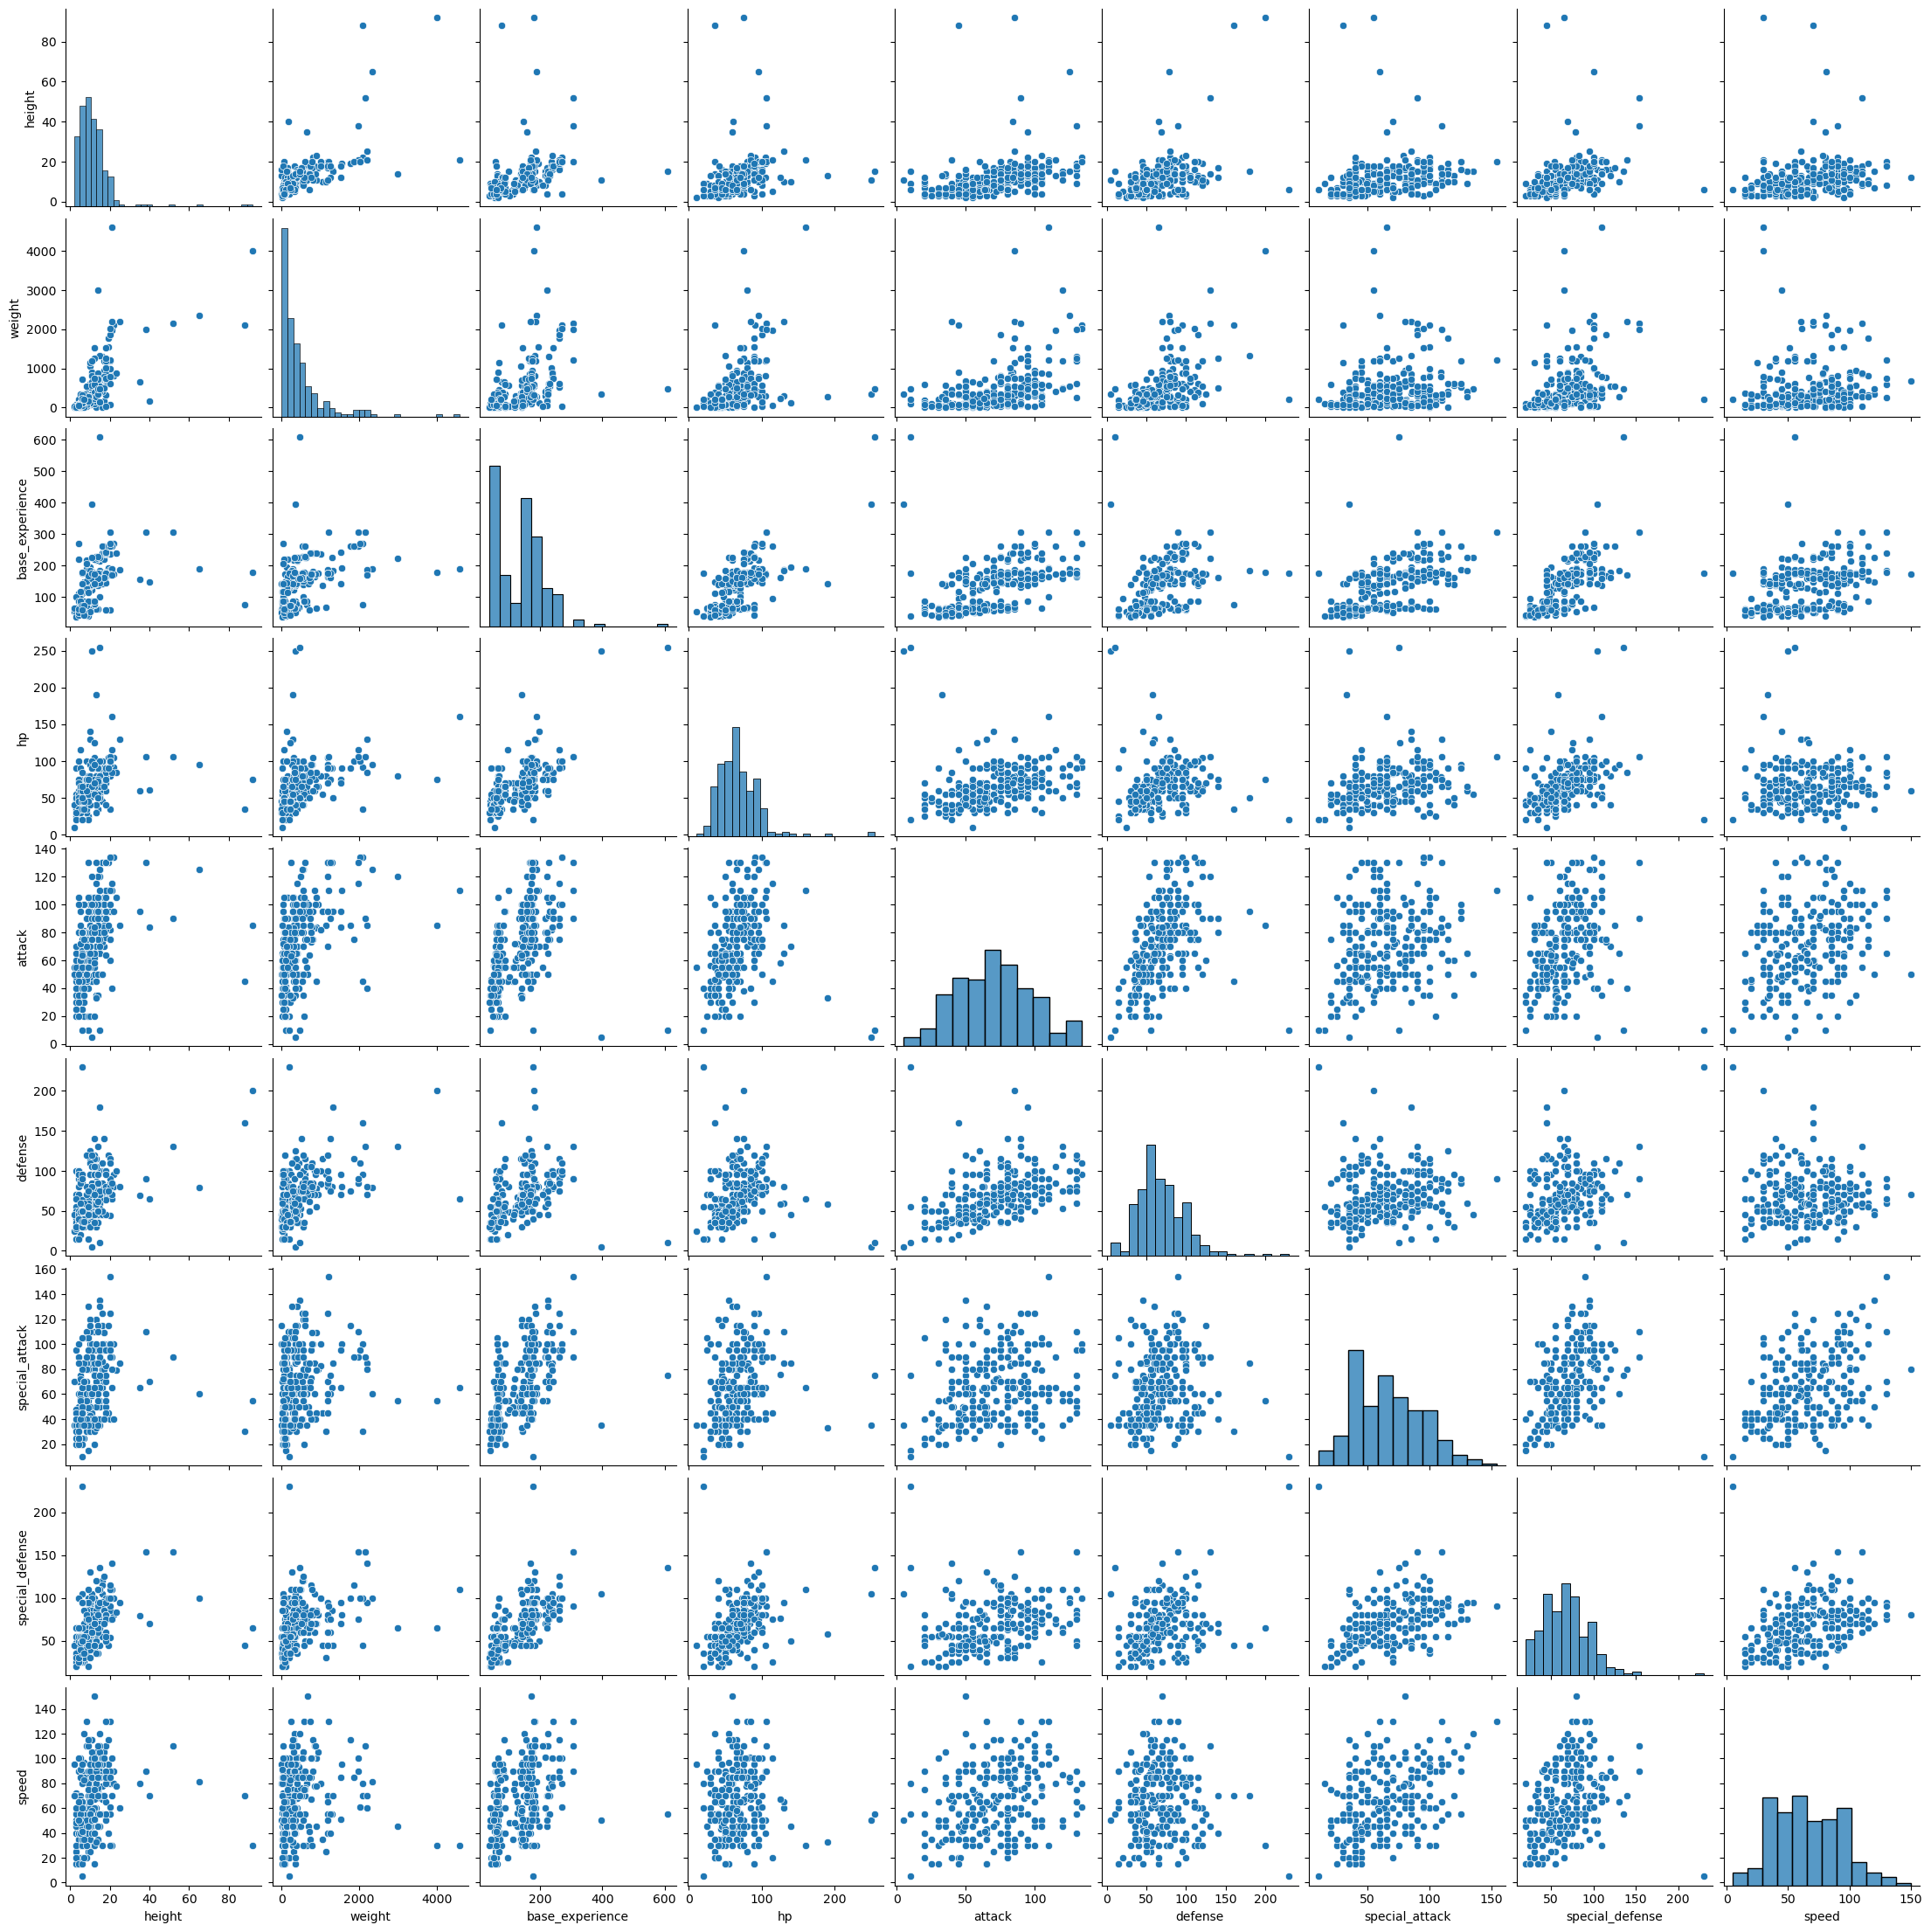

In [5]:
features = df.select_dtypes(include=[np.number]).columns.drop('pokedex_id') # We perform content filtering
X = df[features]

sns.pairplot(X) # We analyze pairwise distributions
plt.show()

At first glance, there appears to be a linear correlation between certain variables, for example, between `hp` and `base_experience`. We can verify these observations using the correlation matrix:

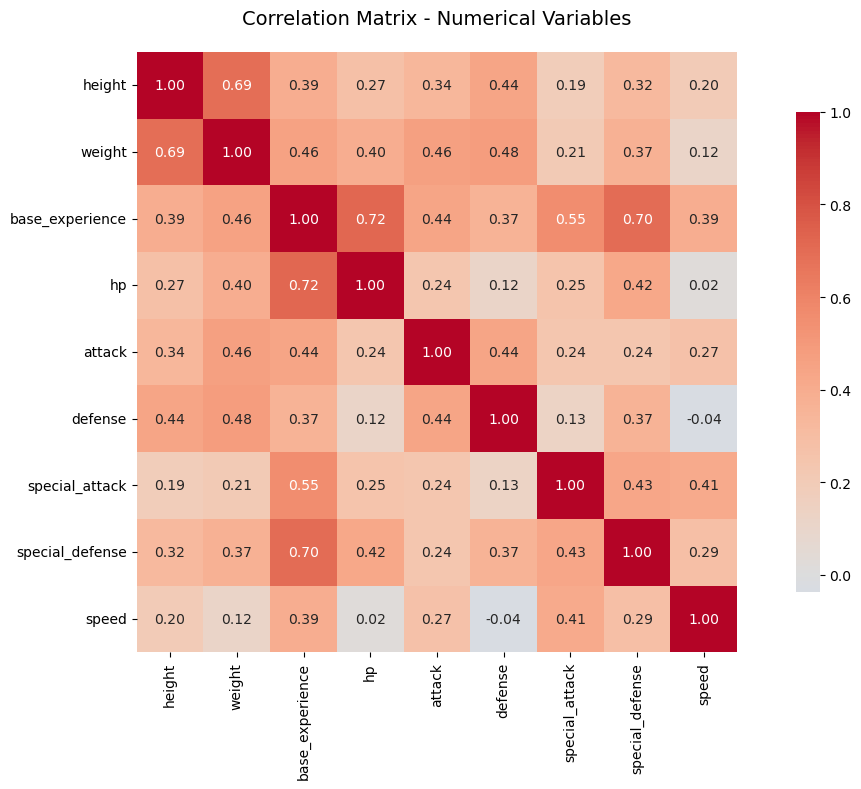

In [6]:
correlation_matrix = X.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix - Numerical Variables', fontsize=14, pad=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Let's focus now on the distribution of each feature:

In [7]:
X.describe()

,height,weight,base_experience,hp,attack,defense,special_attack,special_defense,speed
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,11.844000,473.768000,136.244000,66.776000,70.944000,68.684000,65.952000,68.452000,65.880000
std,10.117962,617.573294,74.252368,29.779879,27.462806,30.439224,27.343525,27.463296,27.286109
min,2.000000,1.000000,36.000000,10.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,6.000000,88.500000,65.000000,48.500000,50.000000,49.250000,45.000000,50.000000,45.000000
50%,10.000000,295.000000,142.000000,65.000000,70.000000,65.000000,64.000000,65.000000,65.000000
75%,15.000000,576.250000,175.000000,80.000000,90.000000,85.000000,85.000000,84.500000,85.000000
max,92.000000,4600.000000,608.000000,255.000000,134.000000,230.000000,154.000000,230.000000,150.000000


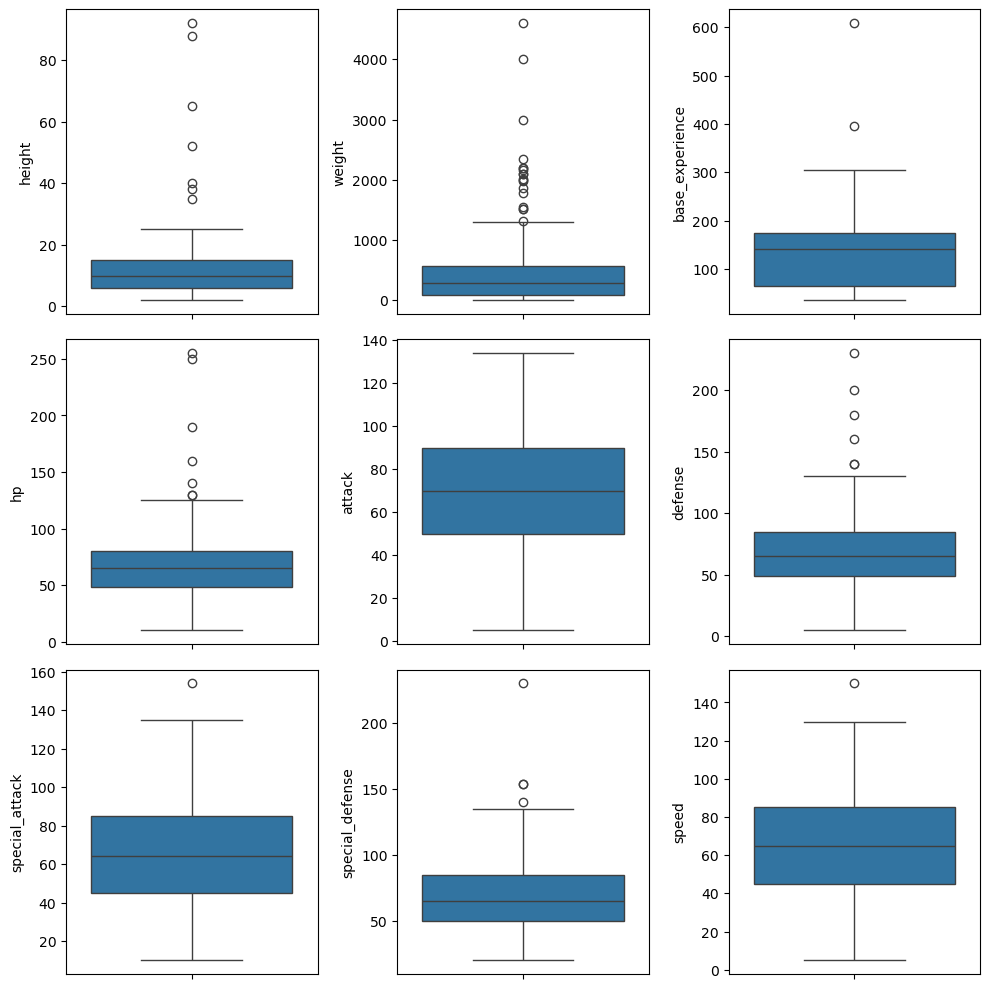

In [8]:
plt.figure(figsize = (10, 10))
for i, feat in enumerate(features):
    plt.subplot(3, 3, i+1) # We create boxplots to search for outliers in each feature
    sns.boxplot(data = X[feat])
plt.tight_layout()
plt.show()


Both the description and the boxplot reveal that the dataset exhibits variables with very different scales and a significant presence of outliers, especially in `weight` and `base_experience` due to their high standard deviation. Combat statistics show a more uniform distribution, suggesting a balanced design of Pokémon characteristics. These results indicate the need to apply scaling techniques and, potentially, outlier treatment before training predictive models:

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Modeling and Evaluation

Once we have obtained the above scaling, we will group the Pokémon by class to create a solid formation. For this, I will use `KMeans`. First, let's find the ideal number of clusters using the elbow method and silhouette score:

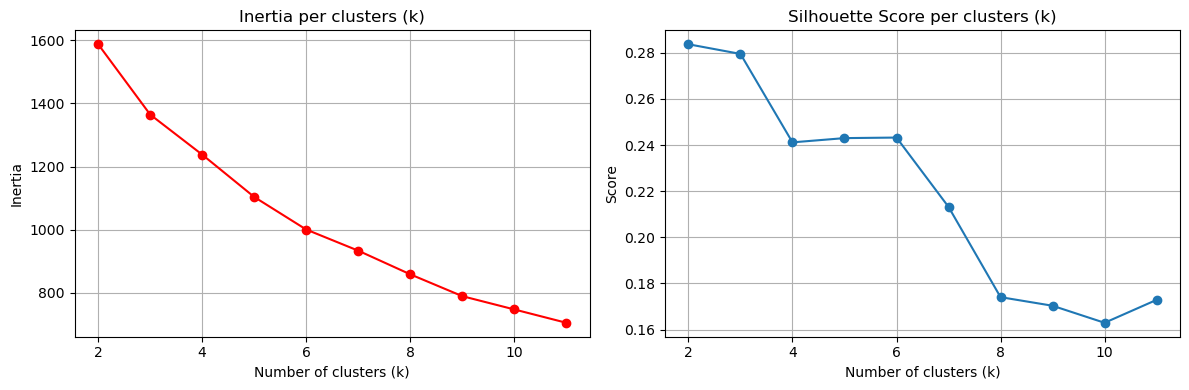

In [10]:
inertia = []
silhouette_scores = []
k_values = range(2, 12)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_) # Inertia capture for each k value
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels) # Silhouette score extraction for each value of k
    silhouette_scores.append(score)

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(k_values, inertia, marker="o", color = "red")
ax[0].set_title("Inertia per clusters (k)")
ax[0].set_xlabel("Number of clusters (k)")
ax[0].set_ylabel("Inertia")
ax[0].grid(True)

ax[1].plot(k_values, silhouette_scores, marker="o")
ax[1].set_title("Silhouette Score per clusters (k)")
ax[1].set_xlabel("Number of clusters (k)")
ax[1].set_ylabel("Score")
ax[1].grid(True)

plt.tight_layout()
plt.show()

The elbow method suggests $k$ values ​​of 5 or 6, as the change in inertia becomes insignificant for larger values. However, the silhouette method shows a peak at $k = 2$, with an inflection point at $k = 4$. Considering the size of the dataset, creating a large number of clusters is not advisable; therefore, I will use $k = 4$ as the midpoint between the two metrics. After applying the clustering model, let's analyze the average characteristics per cluster:

In [11]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled) # We classify

df["cluster"] = clusters # We create a new column with the labels

cluster_summary = df.groupby("cluster")[features].mean() # We analyze general characteristics by cluster and verify the existence of the new column
display(cluster_summary)
df[["name", "cluster"]].head(5)

,height,weight,base_experience,hp,attack,defense,special_attack,special_defense,speed
cluster,,,,,,,,,
0,12.324324,399.747748,164.450450,71.828829,80.009009,76.540541,73.738739,79.234234,76.369369
1,19.555556,1394.166667,241.527778,101.361111,93.555556,90.388889,89.972222,94.750000,72.972222
2,81.666667,2816.666667,148.333333,68.333333,85.000000,146.333333,48.333333,70.000000,60.333333
3,6.440000,154.300000,66.670000,48.670000,52.320000,49.820000,49.190000,46.970000,51.850000


,name,cluster
0,Bulbasaur,3
1,Ivysaur,0
2,Venusaur,1
3,Charmander,3
4,Charmeleon,0


Based on the data shown by each cluster, we can divide the Pokémon into the following categories: 
* The first cluster (0) has balanced data: It could contain versatile specimens, which may be in their second evolutionary stage.
* In contrast, cluster 1 contains Pokémon with high HP and Attack stats, likely due to having reached their final evolution. They also grant the most experience when defeated.
* Cluster 2 stands out for its defensive capabilities and weight; its members are large, commonly called "Tanks."
* Finally, cluster 3 has the lowest stats in almost all categories, so it could be composed of Pokémon that are in their initial stage and have not yet evolved.

To visualize this separation, I will use PCA and plot the first two principal components.

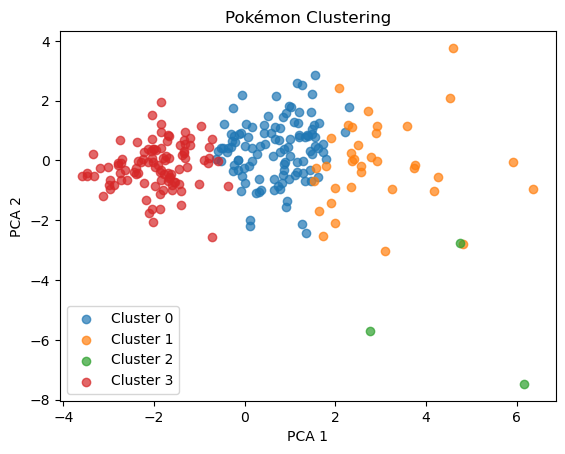

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) # Data transformation for visualization

PCA = pd.DataFrame({'cluster': df['cluster'], 'PC1': X_pca[:, 0],'PC2': X_pca[:, 1]})

plt.figure()
for c in sorted(PCA["cluster"].unique()):
    subset = PCA[PCA["cluster"] == c] # Separation by class for scatter within the graph
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {c}", alpha=0.7)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Pokémon Clustering")
plt.legend()
plt.show()

We can see that there is a cluster with very few elements: Cluster 2. We can verify the above:

In [13]:
df["cluster"].value_counts()


cluster
0    111
3    100
1     36
2      3
Name: count, dtype: int64

To obtain a good evaluation, we will use `RandomOverSampler` to create synthetic samples of the minority class. It is preferable to other methods such as `SMOTE` given its low density.

In [14]:
y = df["cluster"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
) # We separate the original dataset for training and testing

print("Original distribution:")
print(y_train.value_counts())

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train) # We adjust the number of samples after separating to avoid data leakage

print("\nRandomOverSampler distribution:")
print(y_train_res.value_counts())

Original distribution:
cluster
0    83
3    75
1    27
2     2
Name: count, dtype: int64

RandomOverSampler distribution:
cluster
1    83
0    83
3    83
2    83
Name: count, dtype: int64


We will test two different approaches to account for potential linearity in the data: `RandomForestClassifier` and `LogisticRegression`.

In [15]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred_rf, zero_division=0))

Random Forest
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.78      0.78      0.78         9
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00        25

    accuracy                           0.94        63
   macro avg       0.69      0.69      0.69        63
weighted avg       0.94      0.94      0.94        63



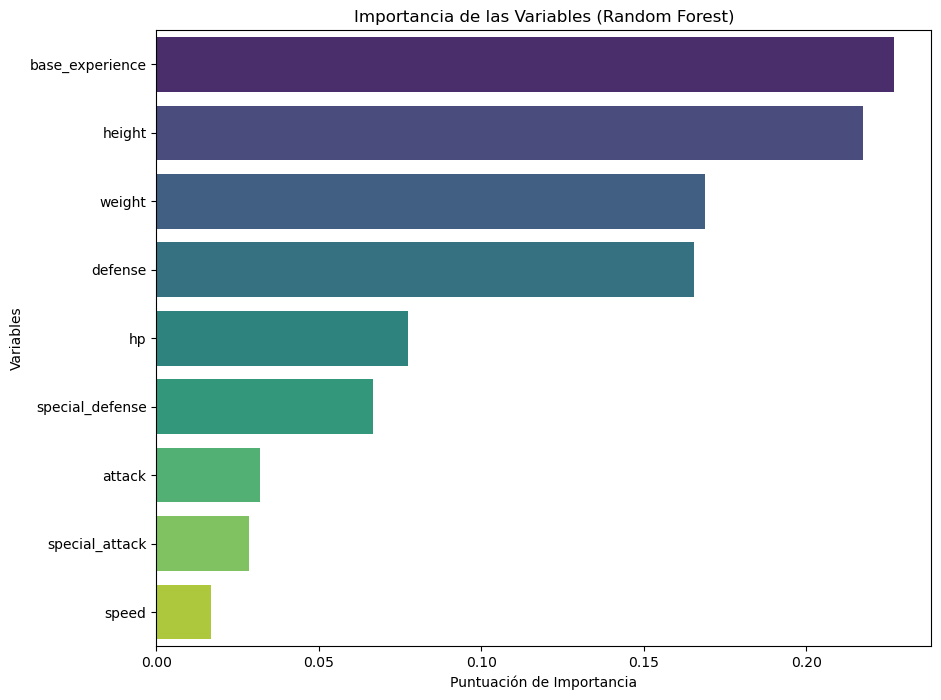

In [16]:
importances = pd.Series(
    rf.feature_importances_,
    index=features
).sort_values(ascending=False) # We extract the relevance of each feature within the dataset for the Random Forest

plt.figure(figsize=(10, 8))
sns.barplot(x=importances.values, y=importances.index, hue=importances.index, palette="viridis", legend=False) # Visualization

plt.title('Importancia de las Variables (Random Forest)')
plt.xlabel('Puntuación de Importancia')
plt.ylabel('Variables')
plt.show()

In [17]:
logreg = Pipeline([
    ("scaler", StandardScaler()), # First, scaling is performed
    ("clf", LogisticRegression( # And then the model is trained
        max_iter=1000,
        random_state=42
    ))
])

logreg.fit(X_train_res, y_train_res)
y_pred_lr = logreg.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr, zero_division=0))

Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        28
           1       0.78      0.78      0.78         9
           2       0.00      0.00      0.00         1
           3       1.00      0.96      0.98        25

    accuracy                           0.92        63
   macro avg       0.67      0.68      0.67        63
weighted avg       0.91      0.92      0.91        63



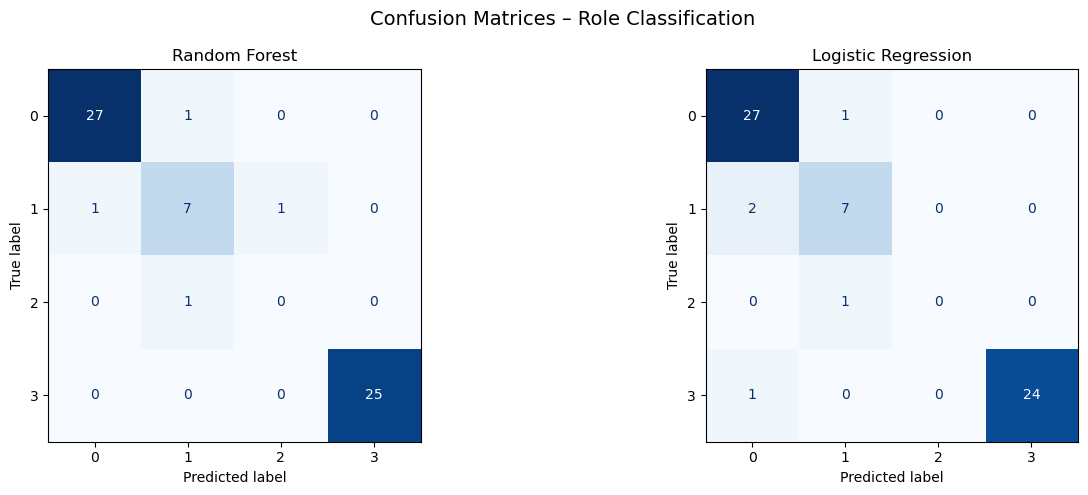

In [18]:
# We visualize the confusion matrices for evaluation purposes for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_rf,
    ax=axes[0],
    colorbar=False,
    cmap="Blues"
)

axes[0].set_title("Random Forest")
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lr,
    ax=axes[1],
    colorbar=False,
    cmap="Blues"
)

axes[1].set_title("Logistic Regression")
fig.suptitle("Confusion Matrices – Role Classification", fontsize=14)
plt.tight_layout()
plt.show()

The results show that RandomForest (94% accuracy) performs slightly better in cluster classification, suggesting that the feature space structure is nonlinear. Logistic regression (92% accuracy), being a linear model, has greater difficulty separating clusters, especially the minority cluster. However, it's worth noting that neither of the two correctly predicted the elements of cluster 2, given the small number of subjects that originally belonged to it. We can therefore consider them outliers, and in future instances, I will use a smaller $k$ when performing the separation for this particular dataset.

### Conclusions

Through Random Forest, we can reliably determine when to defeat or capture a Pokémon based on our needs in the game. For example, it will identify when a Pokémon belongs to a class that provides high attack power or versatility in combat, and when it's not advisable to waste your Poké Balls.

While this analysis isn't entirely applicable to business situations, I believe it's a good starting point in the world of machine learning, allowing me to combine some of my passions in a single project.